# チョコボールのエンゼル出現確率をベイズ推定する

In [1]:
import sys, os
import numpy as np
import pandas as pd
import scipy.stats as stats
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
color_palette = 'deep'
sns.set(context='notebook', style='darkgrid', palette=color_palette, 
        font='sans-serif', font_scale=1.5, color_codes=False, rc=None)
markers = ['.', "x", "s", "+", "v", "p", "^", "<", ">", "1", "2", "3", "4"]
n_markers = len(markers)

In [3]:
np.random.seed(123)

# データの確認
データ構成は以下の通り。

| columns | description |
|:--------|:------------|
| measure_date | 計測日 |
| weight | 総重量 [g] |
| box_weight | 箱重量 [g] |
| ball_number | チョコボールの個数 |
| angel | エンゼルの有無(0:無し, 1:銀のエンゼル, 2:金のエンゼル) |
| campaign | 開催中のキャンペーンID. |
| taste | フレーバーID. choco_tastes.csvを参照. |
| net_weight | 正味重量(weight-box_weight) |
| mean_weight | チョコボール一粒あたりの平均重量(weight/ball_number) |

- campaign=1が 「金のエンゼル２倍キャンペーン」を指している

In [4]:
data = pd.read_csv('data/choco_data.csv')
print(data.shape)
data.head()

(581, 9)


,measure_date,weight,box_weight,ball_number,angel,campaign,taste,net_weight,mean_weight
0,2017-11-19,34.002,4.756,16,0,1,0,29.246,1.827875
1,2017-11-20,34.435,4.805,17,0,1,0,29.630,1.742941
2,2017-11-21,34.000,4.815,18,0,1,0,29.185,1.621389
3,2017-11-22,34.193,4.818,17,0,1,0,29.375,1.727941
4,2017-11-23,35.344,4.836,16,0,1,0,30.508,1.906750


In [5]:
# taste master
tastes = pd.read_csv('data/choco_tastes.csv')
print(tastes.shape)
tastes.head()

(15, 4)


,id,name,name_en,spec
0,0,ピーナツ,peanut,28
1,1,いちご,strawberry,25
2,2,金のきなこもち,kinako,29
3,3,レモングミ,lemon,29
4,4,甘酒,amazake,22


In [6]:
# 集計しやすいように一部のデータを加工
data['silver'] = [1 if y==1 else 0 for y in data['angel']]
data['gold'] = [1 if y==2 else 0 for y in data['angel']]
data['gold_campaign'] = [1 if y==1 else 0 for y in data['campaign']]

In [7]:
data = pd.merge(data, tastes, left_on=['taste'], right_on=['id'], how='left')

In [8]:
pd.concat([data.groupby(['gold_campaign']).count()['name'], 
           data.groupby(['gold_campaign']).sum()['silver'], 
           data.groupby(['gold_campaign']).sum()['gold']
          ], axis=1)

,name,silver,gold
gold_campaign,,,
0,467,22,0
1,114,0,1


In [9]:
df_summary_taste = pd.concat([
    data.groupby(['name']).count()['id'], 
    data.groupby(['name']).sum()['silver'], 
    data.groupby(['name']).sum()['gold'] ], axis=1)
df_summary_taste.sort_values(by=['id'], ascending=False, inplace=True)
print(df_summary_taste.shape)
df_summary_taste

(14, 3)


,id,silver,gold
name,,,
ピーナツ,425,16,1
チョコバナナ,43,2,0
いちご,37,1,0
ミルクキャラメル,16,0,0
ホワイトミルクピーナッツ,14,0,0
パチパチ,10,1,0
甘酒,10,2,0
カスタード,5,0,0
金のきなこもち,5,0,0


# エンゼルの出現有無をモデリング

## MCMC法による近似解の算出

In [10]:
df = data[data['gold_campaign'] < 1]
n_try = len(df['silver'].values)
n_silver = sum(df['silver'])
n_gold = sum(df['gold'])

### 銀のエンゼルの出現確率の推定

In [11]:
n_sample = 1000
with pm.Model() as model_silver:
    # 事前分布
    theta = pm.Beta('theta', alpha=1, beta=1)
    # 尤度
    y = pm.Binomial('y', n=n_try, p=theta, observed=n_silver)

with model_silver:
    # sample
    trace_silver = pm.sample(n_sample, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4522.82draws/s]
The acceptance probability does not match the target. It is 0.8824627247550717, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/tok41/workspace/tech_book/env_tb/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122af6470>,
      dtype=object)

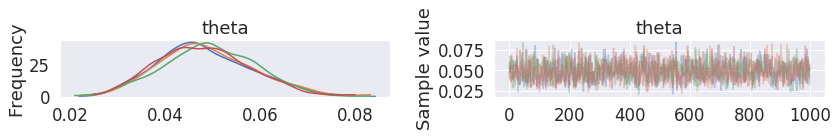

In [12]:
pm.traceplot(trace_silver)

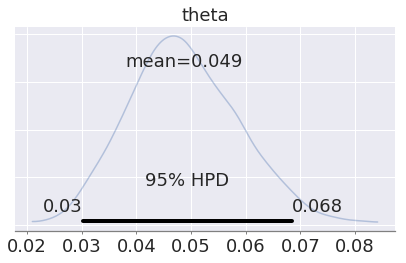

In [13]:
pm.plot_posterior(trace_silver, kde_plot=True, alpha_level=0.05)

### 金のエンゼルの出現確率の推定

In [14]:
with pm.Model() as model_ｇｏｌｄ:
    # 事前分布
    theta = pm.Beta('theta', alpha=1, beta=1)
    # 尤度
    y = pm.Binomial('y', n=n_try, p=theta, observed=n_gold)

with model_gold:
    # sample
    trace_gold = pm.sample(n_sample, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5255.40draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/tok41/workspace/tech_book/env_tb/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1251717f0>,
      dtype=object)

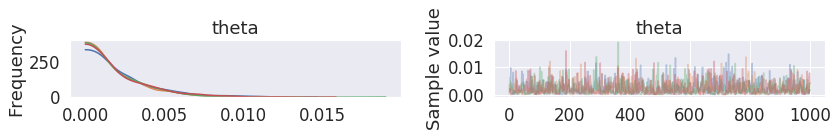

In [15]:
pm.traceplot(trace_gold)

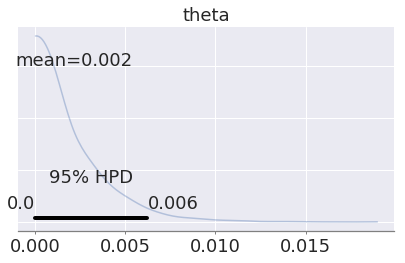

In [16]:
pm.plot_posterior(trace_gold, kde_plot=True, alpha_level=0.05)

## 近似解と解析解の比較
- 解析解はベータ分布として得られる

Text(0.5, 1.0, 'probability of Silver Angel')

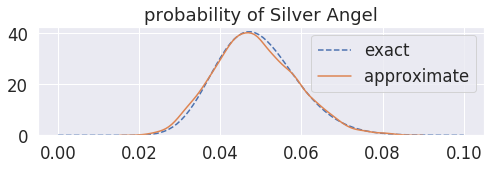

In [17]:
x = np.linspace(0, 0.1, 100) # x軸の設定
fig = plt.figure(figsize=(8, 2))
ax = fig.subplots(1,1)

# 事前分布
a0 = 1.0
b0 = 1.0
# パラメータalphaとbetaを設定
a = a0 + n_silver
b = b0 + (n_try - n_silver)
# ベータ分布の確率密度を計算
y = stats.beta(a, b).pdf(x)
ax.plot(x, y, label='exact', linestyle='--')
sns.distplot(trace_silver['theta'], hist=False, ax=ax, label='approximate')
ax.set_title('probability of Silver Angel')

Text(0.5, 1.0, 'probability of Gold Angel')

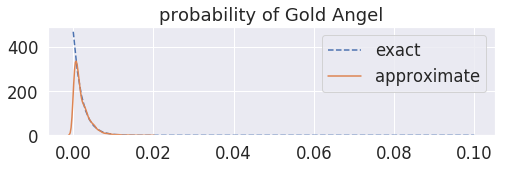

In [18]:
x = np.linspace(0, 0.1, 100) # x軸の設定
fig = plt.figure(figsize=(8, 2))
ax = fig.subplots(1,1)

# 事前分布
a0 = 1.0
b0 = 1.0
# パラメータalphaとbetaを設定
a = a0 + n_gold
b = b0 + (n_try - n_gold)
# ベータ分布の確率密度を計算
y = stats.beta(a, b).pdf(x)
ax.plot(x, y, label='exact', linestyle='--')
sns.distplot(trace_gold['theta'], hist=False, ax=ax, label='approximate')
ax.set_title('probability of Gold Angel')

## おもちゃのカンヅメを得るまでに必要な購入数の見積もり

### 銀のエンゼル

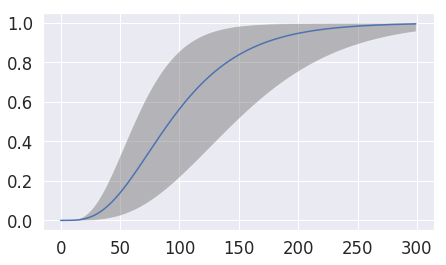

In [19]:
alpha_level = 0.05
n=5  # エンゼルの当たり枚数
ks = np.arange(0,300,1)
p_samples = trace_silver['theta']
# 確率質量
pmf_arr = np.array(list(map(lambda p:stats.nbinom.pmf(ks, n, p), p_samples)))
pmf_expect = pmf_arr.mean(axis=0)
pmf_lb = stats.nbinom.pmf(ks, n, np.percentile(p_samples, (alpha_level*50.0)))
pmf_ub = stats.nbinom.pmf(ks, n, np.percentile(p_samples, (100.0-alpha_level*50.0)))
# 累積確率
cdf_expect = (pmf_arr.cumsum(axis=1)).mean(axis=0)
cdf_nb_lb = pmf_lb.cumsum()
cdf_nb_ub = pmf_ub.cumsum()
# plot
fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1,1)
ax.plot(ks, cdf_expect)
ax.fill_between(ks, cdf_nb_lb, cdf_nb_ub, facecolor='gray',alpha=0.5)

### 金のエンゼル

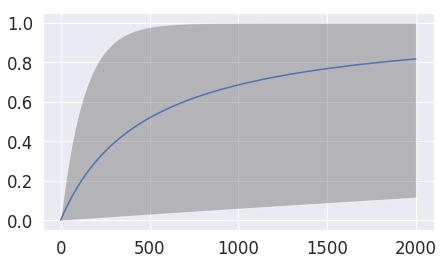

In [20]:
n=1 # エンゼルの当たり枚数
ks = np.arange(0,2000,1)
p_samples = trace_gold['theta']
# 確率質量
pmf_arr = np.array(list(map(lambda p:stats.nbinom.pmf(ks, n, p), p_samples)))
pmf_expect = pmf_arr.mean(axis=0)
pmf_lb = stats.nbinom.pmf(ks, n, np.percentile(p_samples, (alpha_level*50.0)))
pmf_ub = stats.nbinom.pmf(ks, n, np.percentile(p_samples, (100.0-alpha_level*50.0)))
# 累積確率
cdf_expect = (pmf_arr.cumsum(axis=1)).mean(axis=0)
cdf_nb_lb = pmf_lb.cumsum()
cdf_nb_ub = pmf_ub.cumsum()
# plot
fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1,1)
ax.plot(ks, cdf_expect)
ax.fill_between(ks, cdf_nb_lb, cdf_nb_ub, facecolor='gray',alpha=0.5)

# 金のエンゼルと銀のエンゼルの出現確率を合わせて推論

In [21]:
# データの整理
data_0 = data[data['gold_campaign'] < 1] # 通常キャンペーン
data_1 = data[data['gold_campaign'] > 0] # 金のエンゼル２倍キャンペーン

dict_sum = dict()
dict_sum['c0'] = {'gold':sum(data_0['angel']==2), 
                  'silver':sum(data_0['angel']==1), 
                  'none':sum(data_0['angel']==0)
                 }
dict_sum['c1'] = {'gold':sum(data_1['angel']==2), 
                  'silver':sum(data_1['angel']==1), 
                  'none':sum(data_1['angel']==0)
                 }
df_sum = pd.DataFrame(dict_sum).T
df_sum = df_sum[['none', 'silver', 'gold']]
df_sum

,none,silver,gold
c0,445,22,0
c1,113,0,1


## 金のエンゼル２倍キャンペーンを除いたデータで推論

In [22]:
d = df_sum.loc['c0'].values
d

array([445,  22,   0])

In [23]:
n_sample = 10000
with pm.Model() as model1:
    alpha = [1., 1., 1.]
    pi = pm.Dirichlet('pi', a=np.array(alpha))
    m = pm.Multinomial('m', n=np.sum(d), p=pi, observed=d)
    trace1 = pm.sample(n_sample, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [pi]
Sampling 3 chains: 100%|██████████| 31500/31500 [00:11<00:00, 2703.93draws/s]


Text(0.5, 1.0, 'GoldAngel')

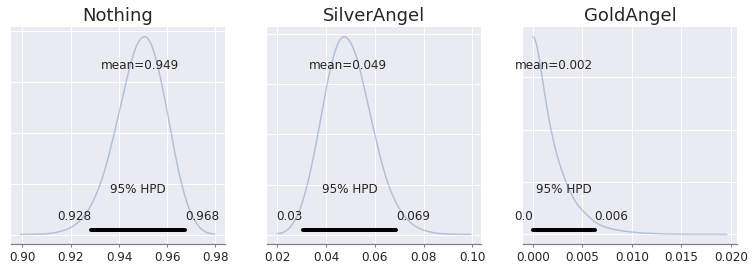

In [24]:
fig = plt.figure(figsize=(13, 4))
ax = fig.subplots(1, 3)

pm.plot_posterior(trace1['pi'][:,0], kde_plot=True, alpha_level=0.05, ax=ax[0])
pm.plot_posterior(trace1['pi'][:,1], kde_plot=True, alpha_level=0.05, ax=ax[1])
pm.plot_posterior(trace1['pi'][:,2], kde_plot=True, alpha_level=0.05, ax=ax[2])
ax[0].set_title('Nothing')
ax[1].set_title('SilverAngel')
ax[2].set_title('GoldAngel')

## 金のエンゼル２倍キャンペーンを含めたデータで推論

In [25]:
d = df_sum.values
d

array([[445,  22,   0],
       [113,   0,   1]])

In [26]:
weight = np.array([[1.0, 1.0, 1.0], 
                   [1.0, 0.0, 2.0]])
weight

array([[1., 1., 1.],
       [1., 0., 2.]])

In [27]:
n_sample = 10000
with pm.Model() as model2:
    alpha = [1., 1., 1.]
    pi = pm.Dirichlet('pi', a=np.array(alpha))
    for i in np.arange(d.shape[0]):
        m = pm.Multinomial('m_%s'%(i), n=np.sum(d[i]), p=pi*weight[i], observed=d[i])
    trace2 = pm.sample(n_sample, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [pi]
Sampling 3 chains: 100%|██████████| 31500/31500 [00:09<00:00, 3346.58draws/s]


Text(0.5, 1.0, 'GoldAngel')

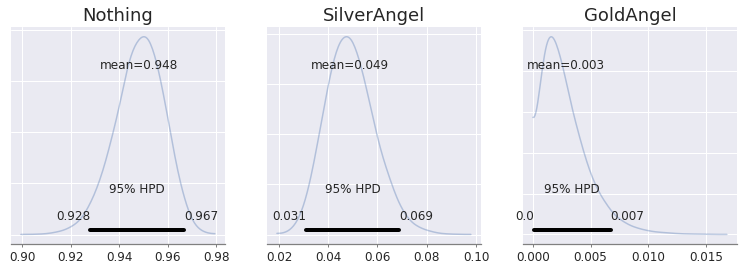

In [28]:
fig = plt.figure(figsize=(13, 4))
ax = fig.subplots(1, 3)

pm.plot_posterior(trace2['pi'][:,0], kde_plot=True, alpha_level=0.05, ax=ax[0])
pm.plot_posterior(trace2['pi'][:,1], kde_plot=True, alpha_level=0.05, ax=ax[1])
pm.plot_posterior(trace2['pi'][:,2], kde_plot=True, alpha_level=0.05, ax=ax[2])
ax[0].set_title('Nothing')
ax[1].set_title('SilverAngel')
ax[2].set_title('GoldAngel')

In [29]:
pm.hpd(trace2['pi'])

array([[9.28001743e-01, 9.66848702e-01],
       [3.09310999e-02, 6.88871293e-02],
       [8.31586181e-05, 6.75162688e-03]])

## おもちゃのカンヅメを得るまでに必要な購入数の見積もり

### 銀のエンゼル

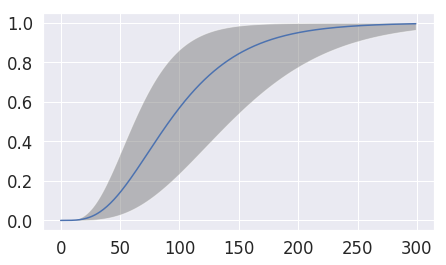

In [30]:
alpha_level = 0.05
n=5  # エンゼルの当たり枚数
ks = np.arange(0,300,1)
p_samples = trace2['pi'][:,1]
# 確率質量
pmf_arr = np.array(list(map(lambda p:stats.nbinom.pmf(ks, n, p), p_samples)))
pmf_expect = pmf_arr.mean(axis=0)
pmf_lb = stats.nbinom.pmf(ks, n, np.percentile(p_samples, (alpha_level*50.0)))
pmf_ub = stats.nbinom.pmf(ks, n, np.percentile(p_samples, (100.0-alpha_level*50.0)))
# 累積確率
cdf_expect = (pmf_arr.cumsum(axis=1)).mean(axis=0)
cdf_nb_lb = pmf_lb.cumsum()
cdf_nb_ub = pmf_ub.cumsum()
# plot
fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1,1)
ax.plot(ks, cdf_expect)
ax.fill_between(ks, cdf_nb_lb, cdf_nb_ub, facecolor='gray',alpha=0.5)

### 金のエンゼル

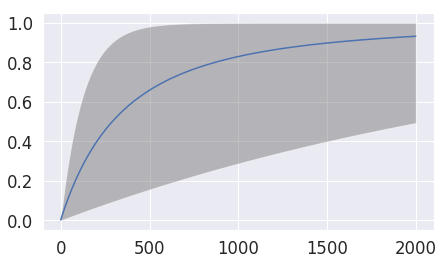

In [31]:
alpha_level = 0.05
n=1  # エンゼルの当たり枚数
ks = np.arange(0,2000,1)
p_samples = trace2['pi'][:,2]
# 確率質量
pmf_arr = np.array(list(map(lambda p:stats.nbinom.pmf(ks, n, p), p_samples)))
pmf_expect = pmf_arr.mean(axis=0)
pmf_lb = stats.nbinom.pmf(ks, n, np.percentile(p_samples, (alpha_level*50.0)))
pmf_ub = stats.nbinom.pmf(ks, n, np.percentile(p_samples, (100.0-alpha_level*50.0)))
# 累積確率
cdf_expect = (pmf_arr.cumsum(axis=1)).mean(axis=0)
cdf_nb_lb = pmf_lb.cumsum()
cdf_nb_ub = pmf_ub.cumsum()
# plot
fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1,1)
ax.plot(ks, cdf_expect)
ax.fill_between(ks, cdf_nb_lb, cdf_nb_ub, facecolor='gray',alpha=0.5)

## 金のエンゼルと銀のエンゼルの価値を比較

(0, 150)

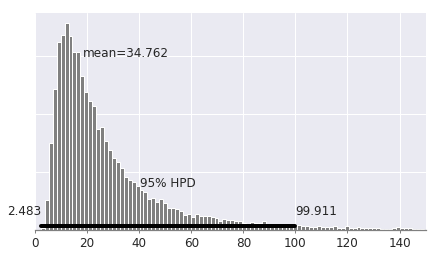

In [32]:
sample_gold = trace2['pi'][:,2]
sample_silver = trace2['pi'][:,1]
sample_rate = sample_silver/sample_gold
bins = np.linspace(0, 150, 100)

fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1,1)
pm.plot_posterior(sample_rate, bins=bins, color='grey', ax=ax)
plt.xlim([0, 150])

In [33]:
print('median :', np.median(sample_rate))

median : 20.267049120709245
